In [1]:
import numpy as np
from scipy.spatial.transform import Rotation as Rot
import scipy.optimize
import scipy.ndimage
import copy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# %matplotlib notebook

In [2]:
#try to package variables/functions into objects
#creation of class(es?) to have stored variables and methods specific to the needs of each map
#then create multiple instances for different maps, seperated within workspace

In [3]:
#file reading function firstly, to be attached to class as method probably (create map from filename argument only)
def zygoread(filename):
    with open(filename, "r") as f:
        fstrings = f.read().split("\"")
        
        fields = []
        data = []
        section = 0
        for elt in fstrings:
            if "#" in elt:  # - use this test to show end of header section, then switch to next section
                section += 1
                pass
            
            if section == 0:  # - processing header section
                #multiple fields are stored within single strings, so need to split by newline to narrow down
                #numbers stored within strings can be extracted afterwards
                #excess artifacts can be filtered out using if (True) test on elements of split string
                #fails on empty string, thus keeping only the relevant fields
                elt = elt.split("\n")
                values = [_ for _ in elt if _]  # - filter bad elements (e.g. "" which have no data and return False)
                #test for non-empty lists (indicates no data was found in values list)
                if values:
                    fields.append(values)
            
            elif section == 1:  # - move to data extraction for intensities and phases
                #the initial split left the both datasets in a single string - separate by "#"
                #split string containing a dataset then iterate through the resulting lines of 10
                #append all values to a 'data' array, filter as before
                #splitting by "#" will result in 2 list stored in the 'data' list
                #i.e. can extract: intensities = data[0], phases = data[1]
                for line in elt.split("#"):
                    values = [_ for _ in line.split() if _]
                    if values:
                        data.append(values)
                
        
        
        
    return fields, data

In [4]:
#want to add rotations as method to zygomap class
#or maybe better to keep as external function, acting on a map object
#could either be general rotation function, then called by optimisation function
#or just retain the optimisation/tilt removal in one function

#general rotations

In [5]:
#specific rotation in x,y (removal of tilts)
#as external function (since moved internal)
def testf(*args):
    angx, angy = args[0]  # - format of scipy minimize requires a single 1st argument to alter - can have list with multiple
    array = args[1]  # - the simple 2D array of height values
    
    dims = array.shape
    x,y = np.indices(dims)  # - create x,y grid values from the array position index (can scale distances later)
    
    #make array of position vectors in Nx3 format: i.e. [x,y,height] as a single element for one point in 3D
    #use dstack to arrange the separate array values down each column, then reshape to Nx3 array
    vectarray = np.dstack([x,y,array])
    vectarray = vectarray.reshape(int(vectarray.size/3), 3)
    
    
    #define rotations around x and y axes respectively and combine via * operation
    rx = Rot.from_rotvec(angx*np.array([1,0,0]))
    ry = Rot.from_rotvec(angy*np.array([0,1,0]))
    r = rx*ry
    
    #apply overall rotation to entire vector array (rotates each vector individually)
    #extract back individual columns and store them in original array dimensions
    newarray = r.apply(vectarray)
#     newx = newarray[:,0].reshape(dims)
#     newy = newarray[:,1].reshape(dims)
    newheights = newarray[:,2].reshape(dims)
    
    #check the peak to valley height of rotated array
    peakvalley = np.nanmax(newheights) - np.nanmin(newheights)    
    
    return peakvalley

In [6]:
def crop(radius):
    #allow user to crop to extract only data within some radius
    #most needed to avoid large edge effects (discontinuities)
    #check for valid (not nan) values in array, and find the positions in array
    #then use the centred x and y positions to check against radius
    #make a new cropped array where points outwith radius are set to nan
    #and "zoom in" to store only the array within the valid range
    
    #make boolean mask to test against radius, using stored x and y (should already be centred for radial comparison)
    outsideR = self.x**2 + self.y**2 > radius**2
    
    cropped = self.heights[:]  # - make copy of heights array (avoid deleting data)
    cropped[outsideR] = np.nan
    
    return cropped

In [7]:
#separate function/method needed to "zoom" to valid data ?
#this would otherwise not happen if crop() not performed
def centre():
    return

In [8]:
class zygomap:
    
    def crop(self, radius=0):
        #allow user to crop to extract only data within some radius
        #most needed to avoid large edge effects (discontinuities)
        #use the (stored) centred x and y positions to check against radius
        #make a new cropped array where points outwith radius are set to nan
        #and "zoom in" to store only the array within the valid range
        #will run during __init__(), with default radius = 0, so can avoid editing if radius is default
        #and only do if user chose a (non-zero) radius
        #thus only the centring of view by array slicing is performed (no need for separate functions)
        
        #set cropped array based on original state of heights (so not cropping multiple times and losing data)
        cropped = self.heights0.copy()
        
        if radius != 0:
            #if radius non-zero, we will be setting valid points to invalid (nan)
            #use centred x,y grid points for full data array to make a mask for points outside radius
            outsideR = self.x**2 + self.y**2 > radius**2
            cropped[outsideR] = np.nan
            
            #could add a flag/callback here to automatically re-apply rotations after crops (otherwise advise user to do it)
            #e.g. if callback = True -> rotateflat()
        
        #now find the extreme bounds of valid points and slice the array to show only the data within
        validrows, validcols = np.where(np.isfinite(cropped))
        lft, rgt, upp, low = np.nanmin(validcols), np.nanmax(validcols), np.nanmin(validrows), np.nanmax(validrows)
        
        cropped = cropped[upp:low+1, lft:rgt+1]
        self.heights = cropped.copy()
        
        return cropped
    
    def testf(self, *args):
        angx, angy = args[0]  # - format of scipy minimize requires a single 1st argument to alter - can have list with multiple
        array = args[1]  # - the simple 2D array of height values

        dims = array.shape
        x,y = np.indices(dims)
        
        #make array of position vectors in Nx3 format: i.e. [x,y,height] as a single element for one point in 3D
        #use dstack to arrange the separate array values down each column, then reshape to Nx3 array
        vectarray = np.dstack([x,y,array])
        vectarray = vectarray.reshape(int(vectarray.size/3), 3)

        #define rotations around x and y axes respectively and combine via * operation
        rx = Rot.from_rotvec(angx*np.array([1,0,0]))
        ry = Rot.from_rotvec(angy*np.array([0,1,0]))
        r = rx*ry

        #apply overall rotation to entire vector array (rotates each vector individually)
        #extract back individual columns and store them in original array dimensions
        newarray = r.apply(vectarray)
        newheights = newarray[:,2].reshape(dims)

        #check the peak to valley height of rotated array
        peakvalley = np.nanmax(newheights) - np.nanmin(newheights)    

        return peakvalley
    
    def rotateflat(self, array):
        #apply minimization
        #call to external testf() (or make testf internal ?)
        #then apply best rotation and return rotated array
        #"array" argument left so normal or cropped maps can be used (i.e. self.heights vs self.cropped)
        
        #minimise peak to valley height for rotation angles around x-axis and y-axis
        opts = {"ftol":1e-15, "xtol":1e-15, "maxiter":1000}
        params = scipy.optimize.minimize(self.testf, x0=[0,0], args=array, tol=1e-15, method="Nelder-Mead", options=opts)
        angx,angy = params["x"]  # - access the optimal angles found by the minimisation
        
        
        #now apply the optimal rotations (same method as contained in test function, "testf")
        dims = array.shape
        x,y = np.indices(dims)
        
        vectarray = np.dstack([x,y,array])
        vectarray = vectarray.reshape(int(vectarray.size/3), 3)
        
        rotx = Rot.from_rotvec(angx*np.array([1,0,0]))
        roty = Rot.from_rotvec(angy*np.array([0,1,0]))
        r = rotx*roty
        
        newarray = r.apply(vectarray)
        newheights = newarray[:,2].reshape(dims)
        
        #centre in z-axis
        newheights -= np.nanmean(newheights)
        
        self.peak, self.valley = np.nanmax(newheights), np.nanmin(newheights)
        self.peakvalley = self.peak - self.valley
        self.rmsHeight = np.sqrt(np.nanmean(newheights**2))
        
        #update the stored heights array
        self.heights = newheights.copy()
        
        return newheights
    
    
    def __init__(self, filename=None, array=None):
        if filename is not None:
            self.filename = filename
            #get header and data from file by user-defined function "zygoread" (change to class method ?)
            fields, data = zygoread(filename)

            #header extraction
            self.stringConstant = fields[0][0]
            chunk = fields[0][1].split()
            self.softwareType, self.majorVersion, self.minorVersion, self.bugVers = [int(n) for n in chunk]

            self.softwareDate = fields[1][0]

            chunk = fields[2][0].split()
            self.intensOriginX, self.intensOriginY, self.intensWidth, self.intensHeight, self.Nbuckets, self.intensRange = [int(n) for n in chunk]

            chunk = fields[2][1].split()
            self.phaseOriginX, self.phaseOriginY, self.phaseWidth, self.phaseHeight = [int(n) for n in chunk]

            self.comment = fields[3][0]

            self.partSerNum = fields[4][0]
            self.partNum = fields[5][0]

            chunk = fields[6][0].split()
            self.source = int(chunk.pop(0))
            self.timeStamp = int(chunk.pop(-1))
            self.intfScaleFactor, self.wavelengthIn, self.numericAperture, self.obliquityFactor, self.magnification, self.cameraRes = [float(n) for n in chunk]

            chunk = fields[6][1].split()
            self.cameraWidth, self.cameraHeight, self.systemType, self.systemBoard, self.systemSerial, self.instrumentId = [int(n) for n in chunk]

            self.objectiveName = fields[7][0]

            #want both index 6 & 7 seperately, as they need to be floats
            #convert the rest to int as before
            chunk = fields[8][0].split()  # - looks messier but should use this throughout to reduce repeated splitting
            self.targetRange = float(chunk.pop(6))  # - remove item at index 6 and returns it (and modifies original list)
            self.lightLevel = float(chunk.pop(6))  # - do it again as the index 7 is now at index 6 in the modified list
            self.acquireMode, self.intensAvgs, self.PZTCal, self.PZTGain, self.PZTGainTolerance, self.AGC, self.minMod, self.minModPts = [int(n) for n in chunk]

            chunk = fields[8][1].split()
            self.disconFilter = float(chunk.pop(4))
            self.phaseRes, self.phaseAvgs, self.minimumAreaSize, self.disconAction, self.connectionOrder, self.removeTiltBias, self.dataSign, self.codeVType = [int(n) for n in chunk]

            self.subtractSysErr = int(fields[8][2])

            self.sysErrFile = fields[9][0]

            chunk = fields[10][0].split()
            self.refractiveIndex, self.partThickness = [float(n) for n in chunk]

            self.zoomDesc = fields[11][0]


            #extract intensity and phase data as numpy arrays (reshape to header parameters)
            self.intensitymap = np.array(data[0], dtype=float).reshape(self.intensHeight, self.intensWidth)
            self.phasemap = np.array(data[1], dtype=float).reshape(self.phaseHeight, self.phaseWidth)

            #handle invalid values (given in MetroPro manual)
            self.intensitymap[self.intensitymap >= 64512] = np.nan
            self.phasemap[self.phasemap >= 2147483640] = np.nan

            #create arrays in terms of number of waves, and height itself (in metres)
            #by given formula
            if self.phaseRes == 0:
                self.R = 4096
            elif self.phaseRes == 1:
                self.R = 32768
            self.waves = self.phasemap*(self.intfScaleFactor*self.obliquityFactor)/self.R
            self.heights = self.waves*self.wavelengthIn
             
        elif array is not None:
            #allow map object to be created from scratch (i.e. make interface as a map object directly)
            self.heights = array.copy()
            
        
        ########################
        ########################
        ##pre-processing maps
        
        #grid points for use in some methods (just using array i,j position index (can scale later))
        self.y, self.x = np.indices(self.heights.shape)
        
        #apply cropping first (user-defined radius ? or default ?)
        #self.cropped = self.crop(self.heights)
        #orderings/logistics of this needs fixed: which array is edited? when? what effect should user cropping give?
        #create a copy of the initial height array, this allows crop to act on those values and provide new self.heights
        #without data loss
        self.heights0 = self.heights.copy()
#         self.cropped = self.heights[:]  # - slice notation actually still links the variables, need np.copy() instead
        
        #adjust to centre of valid points (centre of surface)
        self.validrows, self.validcols = np.where(np.isfinite(self.heights0))
        self.centre = int(np.nanmean(self.validrows)), int(np.nanmean(self.validcols))
        self.x -= self.centre[1]
        self.y -= self.centre[0]
        
        self.crop()
        
        #remove tilt if present
        self.heights = self.rotateflat(self.heights)
        
        
        #moved below into rotateflat(), so they are automatically recalculated
        #storing: self.peak, self.valley, self.peakvalley, self.rmsHeight
        #based on the rotated map (i.e. not stored unless rotation performed (would be inaccurate but could do for completeness))
        # - could make a separate function, to be performed at any time but is there any point ?
        #centring in z-axis
#         self.heights -= np.nanmean(self.heights)
        
        #end calculations
#         self.peakvalley = np.nanmax(self.heights) - np.nanmin(self.heights)
        
        return

In [9]:
map1 = zygomap("M1.txt")
map1.heights

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [10]:
map1.peakvalley

8.654055354657178e-08

In [11]:
map1.heights

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [12]:
#example crop, and rotation - below see reduced peakvalley height
map1.crop(30)
map1.rotateflat(map1.heights)

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [13]:
map1.peakvalley

3.830410234903091e-08

In [14]:
# map2.peakvalley

In [15]:
map1.rmsHeight

8.973179748335544e-09

#### map comparisons

In [16]:
map1 = zygomap("M1.txt")
map2 = zygomap("M2.txt")

In [17]:
map1.crop(30)
map2.crop(30)

#after cropping, should re-apply rotations as removed edges likely had a large effect and need the result without them
#could make that automatic after crop(), but for now have user do it manually
map1.rotateflat(map1.heights)
map2.rotateflat(map2.heights)

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [18]:
print(map1.heights.shape)
print(map2.heights.shape)

(61, 61)
(61, 61)


In [19]:
#process: flip one map and negate its values; the interface should be the sum of the heights
#have to protect against non-physical intersections (i.e. negative values in interface)
#rotation around z-axis may provide different values - could possibly optimise this
flipped = -map2.heights[::-1]  # - should ensure cropped both to same shape
interface = map1.heights + flipped

#correct for impossible intersection of maps
#by adding back the magnitude of largest transgression (largest negative in interface)
interface += abs(np.nanmin(interface))

#centre in z-axis around mean
interface -= np.nanmean(interface)

In [20]:
#construct map object for interface array (for simple, direct access to attributes and processes)
interfacemap = zygomap(array=interface)

In [21]:
interfacemap.peakvalley

6.388808111043491e-08

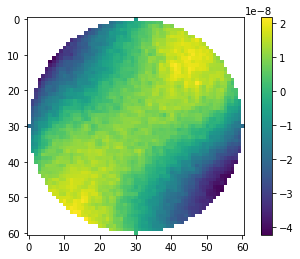

In [22]:
plt.imshow(interfacemap.heights)
plt.colorbar()
plt.show()

/local/environments/gw/gw-venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  


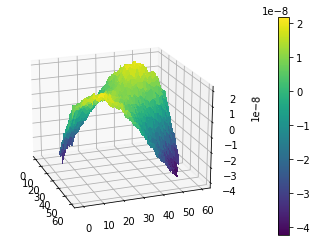

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111,projection="3d")
ax.set_zlim(interfacemap.valley, interfacemap.peak)

x,y = np.indices(interfacemap.heights.shape)

current_cmap = copy.copy(cm.get_cmap("viridis"))
p = ax.plot_surface(x,y,interfacemap.heights, vmin=interfacemap.valley, vmax=interfacemap.peak, antialiased=False, cmap=current_cmap)
# p.cmap.set_bad("black", alpha=1)

plt.colorbar(p, pad=0.16)

ax.view_init(elev=20, azim=-20)

plt.show()

#### optimise rotation for interface (around z-axis)

In [24]:
#redefine ztestf() to work with scipy.ndimage.rotate

def ztestf(*args):
    angz = args[0][0]  # - optimize.minimize gives angz as [0.] (why?) so needs extracted from list as well as args tuple
    lowermap, uppermap = args[1],args[2]

    dims = uppermap.heights.shape
    
    #now get new rotated array (rotating around z/in x-y plane)
    #using scipy.ndimage.rotate()
    newheights = scipy.ndimage.rotate(uppermap.heights, angz, order=0, reshape=False, mode="constant", cval=np.nan)
    
    interface = -newheights[::-1] + lowermap.heights
    interface += abs(np.nanmin(interface))
    interface -= np.nanmean(interface)
    
    peakvalley = np.nanmax(interface) - np.nanmin(interface)
    
    return peakvalley

In [25]:
def combinemaps(lowermap, uppermap, optimised=True):
    #function to combine zygomap objects
    #flips and negates values of the 2nd map "uppermap"
    #emulating the surface placed faced down on the other
    #returns zygomap object from the combination of the lower map and the transformed uppermap
    #where the magnitude of largest negative has been added back as an offset to prevent non-physical overlap of surfaces
    
    #check for equal shapes (change to automatically crop to smallest shared values)
    lowerdims = lowermap.heights.shape
    upperdims = uppermap.heights.shape
    if lowerdims != upperdims:
        
        print("Maps' shapes are not equal")
        return
    
    #find optimised angle of rotation (of uppermap with respect to lowermap)
    #minimise the peakvalley height with rotation angle around z-axis
    #NOTE: previous rotation method not working the same for z rotations
    #using scipy.ndimage.rotate (with order=0 to maintain array values (no spline interpolation))
    #large angular range needed -> need brute() function to get the accurate value
    #define angular range by ranges=(sllice(0,360),) (the slice object is preferred by brute function definition)
    optimalangle = 0
    if optimised == True:
        optimalangle = scipy.optimize.brute(ztestf, ranges=((slice(0,360),)), args=(lowermap,uppermap))[0]
    
    #apply this angle with scipy.ndimage.rotate() to get new array of the rotated uppermap
    #use this array directly for the interface (in place of uppermap.heights), and leave each individual map untouched
    #should store some indicator for user of the optimal angle used (property of interfacemap ?)
    newheights = scipy.ndimage.rotate(uppermap.heights, optimalangle, order=0, reshape=False, mode="constant", cval=np.nan)
    
    

    #flip and negate uppermap, then add to lower map for interface
    interface = -newheights[::-1] + lowermap.heights  # - add check for equal shapes of both maps
    interface += abs(np.nanmin(interface))  # - add back largest overlap, to leave maps just touching
    interface -= np.nanmean(interface)  # - centre in z-axis around mean
        
    #construct as zygomap object
    interfacemap = zygomap(array=interface)
    
    #give user some knowledge on the optimised set-up
    #this could be moved elsewhere possibly for better access
    #add option to set optimisation on/off ?
    if optimised:
        print("Maps combined for optimal angle of {0:.2f} degrees\n\
        {1} clockwise w.r.t {2}".format(optimalangle,map2.filename,map1.filename))
        print("Optimised peak-to-valley height: {0} m".format(interfacemap.peakvalley))
    
    return interfacemap

interfacemap = combinemaps(map1,map2)

Maps combined for optimal angle of 288.00 degrees
        M2.txt clockwise w.r.t M1.txt
Optimised peak-to-valley height: 3.150101061617541e-08 m


In [26]:
# combinemaps(map1,map2,optimised=False)

In [27]:
x,y = np.indices(map1.heights.shape)
centre = int(np.nanmean(map1.validrows)), int(np.nanmean(map1.validcols))

# vectarray = np.dstack([x - centre[1],y - centre[0],map1.heights])
vectarray = np.dstack([x, y, map1.heights])
vectarray = vectarray.reshape(int(vectarray.size/3),3)

rz = Rot.from_rotvec(np.pi/4*np.array([0,0,1]))
newarray = rz.apply(vectarray)
# newarray[:,0] += centre[1]
# newarray[:,1] += centre[0]

# np.sort(np.sort(newarray, axis=0), axis=0)
# a = newarray[vectarray[:,2].argsort()]
# a = a[a[:,1].argsort(kind="mergesort")]
# a = a[a[:,0].argsort(kind="mergesort")]

a = newarray[np.where(np.isfinite(newarray[:,2]))]

In [28]:
a[np.lexsort((a[:,2], a[:,1], a[:,0]))]

array([[-2.96984848e+01,  3.81837662e+01,  4.33209104e-10],
       [-2.96984848e+01,  3.95979797e+01, -3.06437025e-10],
       [-2.96984848e+01,  4.38406204e+01,  4.19631911e-10],
       ...,
       [ 2.96984848e+01,  4.24264069e+01,  9.43570760e-09],
       [ 2.96984848e+01,  4.38406204e+01,  1.02216718e-08],
       [ 2.96984848e+01,  4.52548340e+01,  1.10269476e-08]])

In [29]:
#rotate only valid points, then sort them into index order to re-insert heights in new positions
a = vectarray[np.where(np.isfinite(vectarray[:,2]))]
a = rz.apply(a)
a

array([[-2.12132034e+01,  2.12132034e+01, -1.68220814e-08],
       [-1.55563492e+01,  1.69705627e+01, -2.07877510e-08],
       [-1.62634560e+01,  1.76776695e+01, -1.87562952e-08],
       ...,
       [ 1.62634560e+01,  6.71751442e+01, -8.85656828e-09],
       [ 1.55563492e+01,  6.78822510e+01, -9.84736595e-09],
       [ 2.12132034e+01,  6.36396103e+01, -3.44274744e-09]])

In [30]:
a = a[np.lexsort((a[:,2], a[:,1], a[:,0]))]
a

array([[-2.96984848e+01,  3.81837662e+01,  4.33209104e-10],
       [-2.96984848e+01,  3.95979797e+01, -3.06437025e-10],
       [-2.96984848e+01,  4.38406204e+01,  4.19631911e-10],
       ...,
       [ 2.96984848e+01,  4.24264069e+01,  9.43570760e-09],
       [ 2.96984848e+01,  4.38406204e+01,  1.02216718e-08],
       [ 2.96984848e+01,  4.52548340e+01,  1.10269476e-08]])

In [31]:
np.array(a, dtype=int)

array([[-29,  38,   0],
       [-29,  39,   0],
       [-29,  43,   0],
       ...,
       [ 29,  42,   0],
       [ 29,  43,   0],
       [ 29,  45,   0]])

In [32]:
#have sorted the array of vectors from map1.heights and stored the rotated vector array in "a"
#let "c" be the intermediate variable (avoid overwriting the data whil testing)
#for the valid points in c, edit these heights with the values from rotated array (last column is heights)
#the rotated array has been re-ordered, so that the points will be in array position order, ready to be inserted in-place
c = map1.heights.copy()
c[np.where(np.isfinite(c))] = a[:,2]
c

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

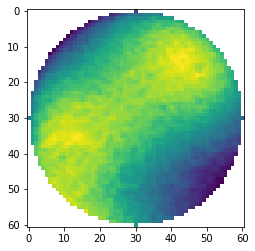

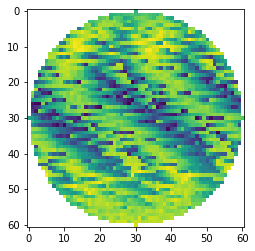

In [33]:
plt.imshow(map1.heights)
plt.show()
plt.imshow(c)
plt.show()
#45 degree rotation shows the off-axis problems - grid points not matching rotated order.

In [34]:
opts = {"ftol":1e-15, "xtol":1e-15, "maxiter":1000}
params = scipy.optimize.minimize(ztestf, x0=0, args=(map1,map2), tol=1e-15, method="Nelder-Mead", options=opts)
# angz = params["x"]  # - access the optimal angle found by the minimisation
params

 final_simplex: (array([[0.00000000e+00],
       [9.09494702e-16]]), array([6.59707606e-08, 6.59707606e-08]))
           fun: 6.597076060426526e-08
       message: 'Optimization terminated successfully.'
          nfev: 116
           nit: 39
        status: 0
       success: True
             x: array([0.])

In [35]:
#the solution using ndimage interpolator, which handles off-grid rotations well
#it's also very fast, even at order 1 of interpolation (order 0 is none)
#works for order 0 or 1, any higher and can't handle nan values (all nan array returned)
#reshape=False, to keep same size of array; mode="constant" with cval set to fill the unspecified points with nan values
d1 = scipy.ndimage.rotate(map1.heights, 45, order=1, reshape=True, mode="constant", cval=np.nan)
d2 = scipy.ndimage.rotate(map1.heights, 45, order=1, reshape=False, mode="constant", cval=np.nan)
# d

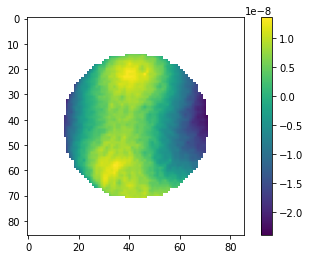

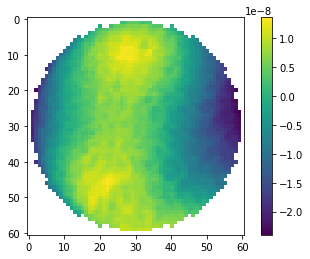

In [36]:
#how different are the results for each order ?
# plt.imshow(d1 - d2)
# plt.show()
plt.imshow(d1)
plt.colorbar()
plt.show()
plt.imshow(d2)
plt.colorbar()
plt.show()

In [37]:
maxdiff = 0
for angle in range(180):
    d1 = scipy.ndimage.rotate(map1.heights, angle, order=0, reshape=False, mode="constant", cval=np.nan)
    d2 = scipy.ndimage.rotate(map1.heights, angle, order=1, reshape=False, mode="constant", cval=np.nan)
    
    if abs(np.nanmax(d1 - d2)) > maxdiff:
        maxdiff = np.nanmax(d1 - d2)
        
print(maxdiff)
print(map1.peakvalley)
print(maxdiff/map1.peakvalley)  # - error on order of 1/10th of peak-valley height (significant ?)
#looks like the interpolation is changing the data a bit too far from the measurements

3.906866078154253e-09
3.830410234903091e-08
0.10199602232038983


In [38]:
np.nanmax(d1), np.nanmax(d2)

(1.3659077659655877e-08, 1.3638350927280025e-08)

In [39]:
np.nanmin(d1), np.nanmin(d2)

(-2.464502468937503e-08, -2.401582762158384e-08)

In [40]:
#minimisation seems to depend heavily on input "guess" (x0) as to how it finds the minimum
#large angles most likely to show major differences if any exist
#trial some guesses, in the (0,180) degrees range (NOTE: scipy.ndimage.rotate uses degrees; radians used before but not here)
#minimise for angle near each guess, and choose the best option (approximate or accurate is hard to tell)

minpv = combinemaps(map1,map2, optimised=False).peakvalley  # - initial best result is the standard peakvalley of interface
optimalangle = 0
for angle in np.linspace(0,360, 10):
    params = scipy.optimize.minimize(ztestf, x0=angle, args=(map1,map2), tol=1e-15, method="Nelder-Mead", options=opts)
    if params["fun"] < minpv:
        minpv = params["fun"]
        optimalangle = params["x"][0]
        
print(optimalangle, minpv)

288.0 3.252590683784117e-08


In [41]:
#will get different results if using "(0,360)" vs. "slice(0,360)" slice object
# - the slice object is the preferred input and gives the right minimum
scipy.optimize.brute(ztestf, ranges=(slice(0,360),), args=(map1,map2))

array([288.])

In [42]:
ztestf([288.], map1,map2)

3.252590683784117e-08

In [43]:
#compared to non-slice (giving wrong value)
scipy.optimize.brute(ztestf, ranges=((0,360),), args=(map1,map2))

array([278.21546053])

In [44]:
ztestf([278.21546053], map1,map2)

3.308140775285952e-08

In [45]:
%%timeit
minpv = interfacemap.peakvalley  # - initial best result is the standard peakvalley of interface
optimalangle = 0
for angle in np.linspace(0,360, 10):
    params = scipy.optimize.minimize(ztestf, x0=angle, args=(map1,map2), tol=1e-15, method="Nelder-Mead", options=opts)
    if params["fun"] < minpv:
        minpv = params["fun"]
        optimalangle = params["x"][0]

900 ms ± 17.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [46]:
#quick enough to compute brute-force optimisation (removes need for loop of guess angles) and is faster actually
%timeit scipy.optimize.brute(ztestf, ranges=(slice(0,360),), args=(map1,map2))

247 ms ± 2.97 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [47]:
#showing the brute force result as a guess is accurate with regular minimize() Nelder-Mead method from before
scipy.optimize.minimize(ztestf, x0=optimalangle, args=(map1,map2), tol=1e-15, method="Nelder-Mead", options=opts)

 final_simplex: (array([[288.],
       [288.]]), array([3.25259068e-08, 3.25259068e-08]))
           fun: 3.252590683784117e-08
       message: 'Optimization terminated successfully.'
          nfev: 143
           nit: 50
        status: 0
       success: True
             x: array([288.])

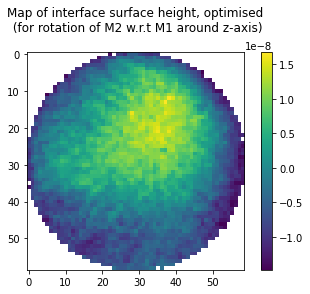

In [48]:
plt.imshow(interfacemap.heights)
plt.title("Map of interface surface height, optimised\n (for rotation of M2 w.r.t M1 around z-axis)\n")
plt.colorbar()
plt.show()

/local/environments/gw/gw-venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  


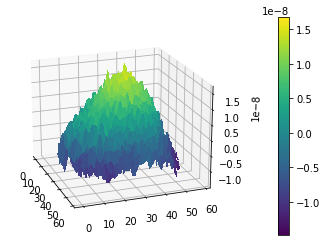

In [49]:
fig = plt.figure()
ax = fig.add_subplot(111,projection="3d")
ax.set_zlim(interfacemap.valley, interfacemap.peak)

x,y = np.indices(interfacemap.heights.shape)

current_cmap = copy.copy(cm.get_cmap("viridis"))
p = ax.plot_surface(x,y,interfacemap.heights, vmin=interfacemap.valley, vmax=interfacemap.peak, antialiased=False, cmap=current_cmap)
# p.cmap.set_bad("black", alpha=1)

plt.colorbar(p, pad=0.16)

ax.view_init(elev=20, azim=-20)

plt.show()

In [50]:
print(combinemaps(map1,map2, optimised=False).peakvalley)
print(combinemaps(map1,map2, optimised=False).rmsHeight)

6.388808111043491e-08
1.4421456967770605e-08


In [52]:
print(interfacemap.peakvalley)
print(interfacemap.rmsHeight)

3.150101061617541e-08
7.142078896293826e-09
